🔍 Google Colab 환경에서 실행 중입니다.
📚 라이브러리 임포트 완료!
🔧 TensorFlow 버전: 2.18.0
✅ 데이터셋 경로 확인: /content/cats_and_dogs_filtered

📁 데이터셋 구조:
   훈련 데이터: /content/cats_and_dogs_filtered/train
     - 고양이: 1000장
     - 개: 1000장
   검증 데이터: /content/cats_and_dogs_filtered/validation
     - 고양이: 500장
     - 개: 500장
⚙️ 하이퍼파라미터 설정 완료!
   - 입력 크기: (224, 224, 3)
   - 클래스 수: 2
   - 배치 크기: 32
   - 학습률: 0.0003
   - 에폭 수: 10
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
✅ 데이터셋 생성 완료!
   - 훈련 데이터: 63 배치
   - 검증 데이터: 32 배치
   - 클래스: ['cats', 'dogs']


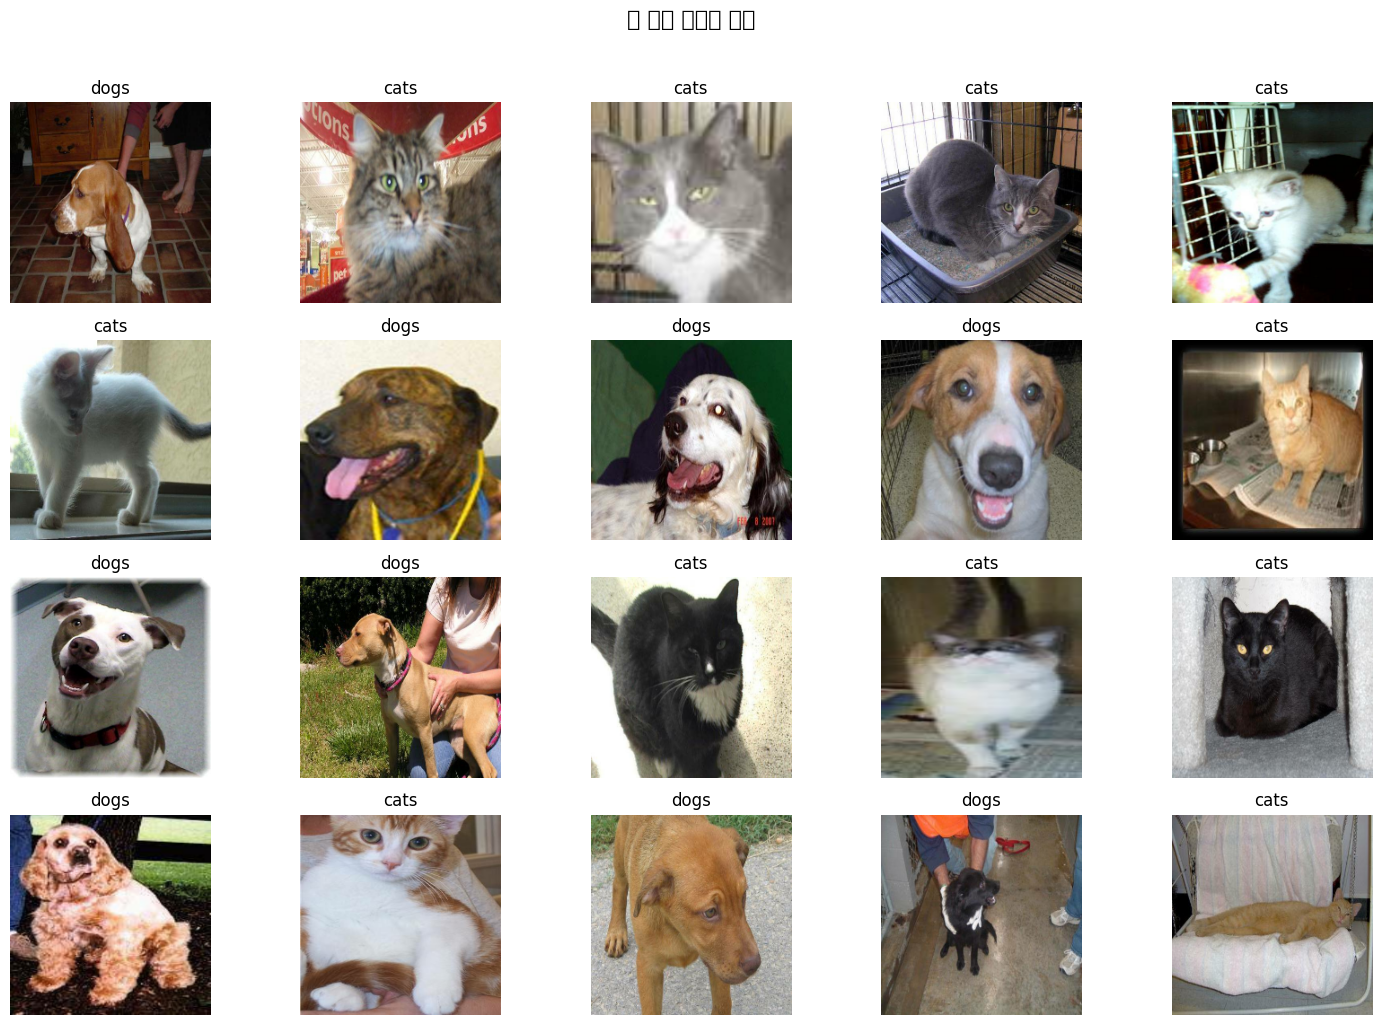

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
🔄 MobileNetV2 사전훈련 모델 로드 완료!
   - 총 레이어 수: 154
   - 출력 형태: (None, 7, 7, 1280)
🔒 베이스 모델 가중치 고정 완료!
🏗️ 모델 구축 완료!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

⚙️ 모델 컴파일 완료!
   - 옵티마이저: Adam (lr=0.0003)
   - 손실 함수: Binary Crossentropy
   - 평가 지표: Accuracy
📞 콜백 함수 설정 완료!
🎓 모델 학습을 시작합니다...
   - 에폭: 10
   - 배치 크기: 32
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5954 - loss: 0.6767
Epoch 1: val_accuracy improved from -inf to 0.95600, saving model to best_mobilenetv2_cats_dogs.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 416ms/step - accuracy: 0.5980 - loss: 0.6741 - val_accuracy: 0.9560 - val_loss: 0.2632 - learning_rate: 3.0000e-04
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9538 - loss: 0.2456
Epoch 2: val_accuracy improved from 0.95600 to 0.98300, saving model to best_mobilenetv2_cats_dogs.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9540 - loss: 0.2449 - val_accuracy: 0.9830 - val_loss: 0.1423 - learning_rate: 3.0000e-04
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9759 - loss: 0.1377
Epoch 3: val_accuracy improved from 0.98300 to 0.98600, saving model to best_mobilenetv2_ca

Saved artifact at 'cats_dogs_mobilenetv2_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137225856770000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822233488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822226576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822232912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822233872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822232720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822234064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822230800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822234640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137225822233296: TensorSpec(shape=(), dtype=tf.resource, name=No

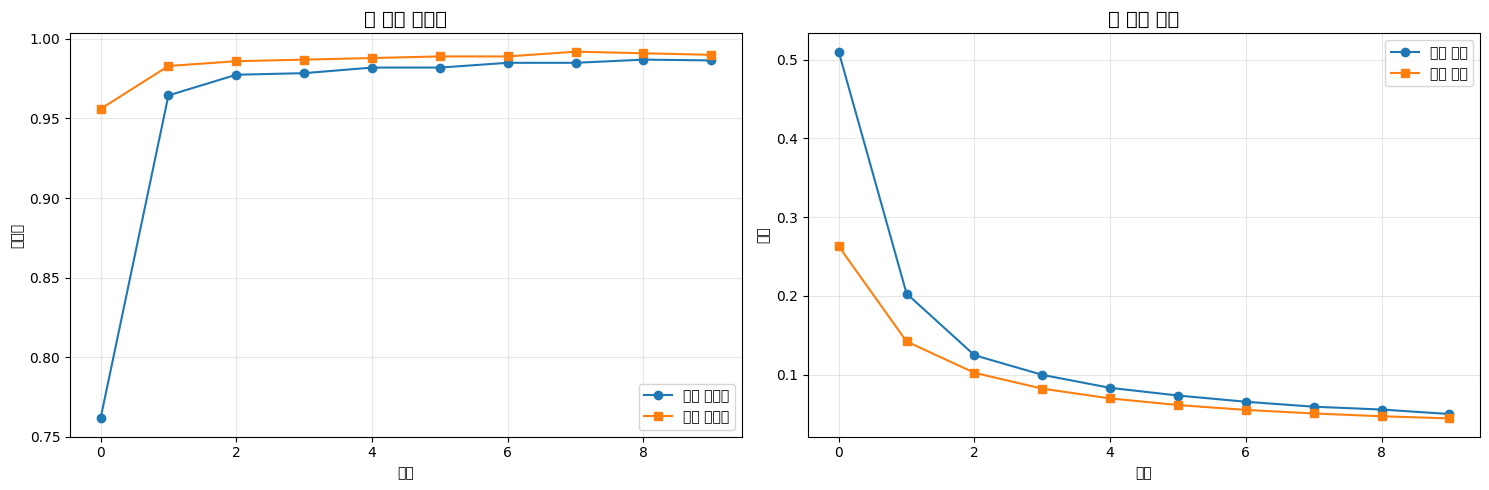

🏆 최고 훈련 정확도: 0.9870
🏆 최고 검증 정확도: 0.9920
📊 모델 평가 중...
✅ 최종 검증 정확도: 0.9920
✅ 최종 검증 손실: 0.0509
🔮 예측 테스트 중...
배치 크기: 32


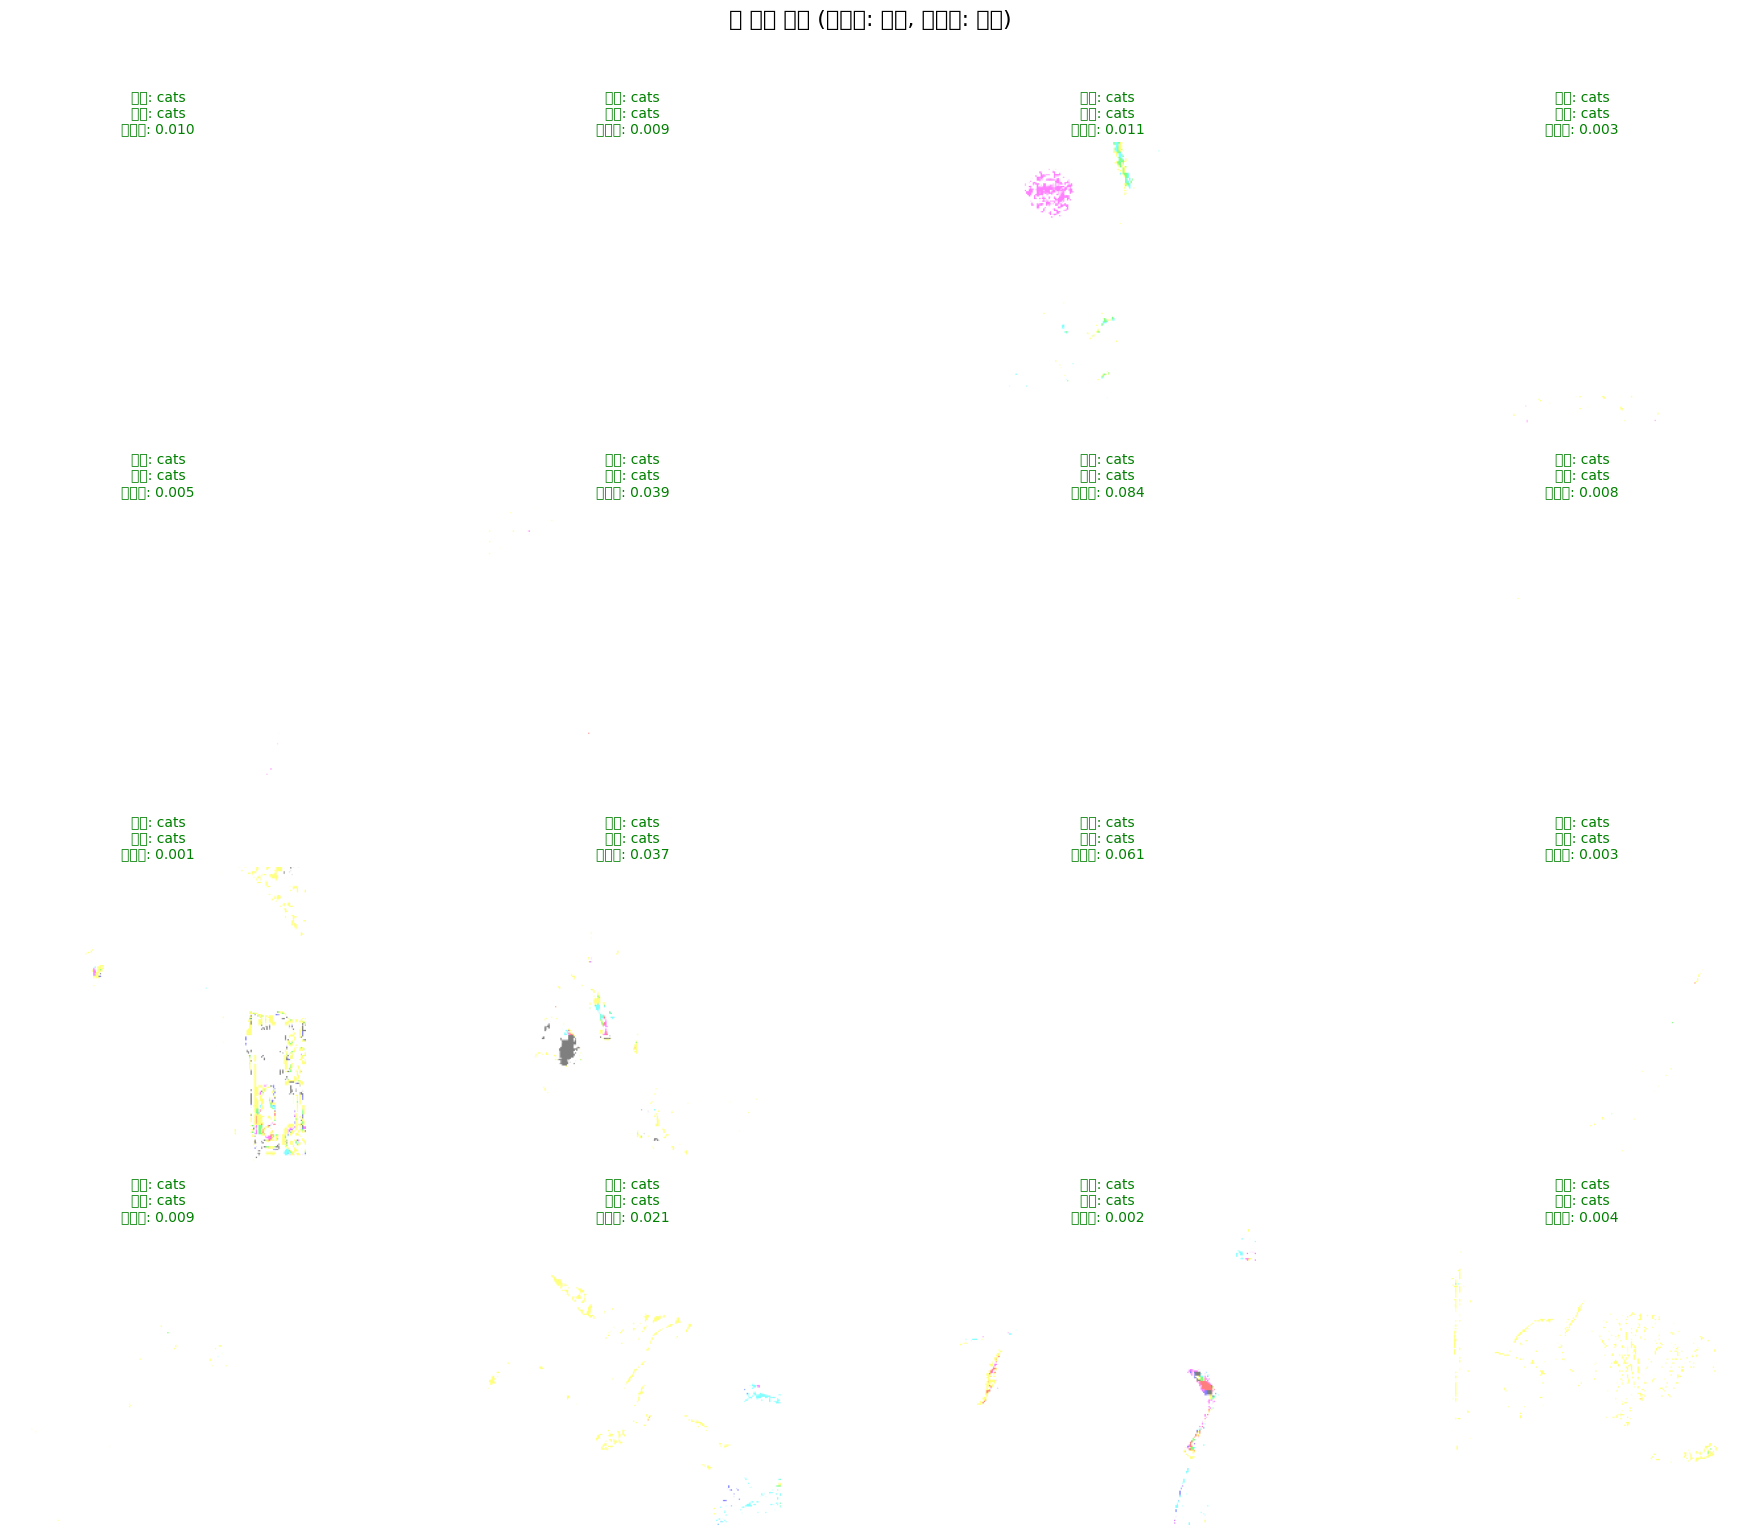

📊 배치 정확도: 32.0000 (1024/32)
🔮 개별 예측 테스트:
   이미지: cat.2283.jpg
   예측: cats
   신뢰도: 0.0236
🐱 고양이 이미지 예측 테스트:
📁 디렉토리 예측 시작: /content/cats_and_dogs_filtered/validation/cats
📊 총 500개 이미지 발견
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step
📊 고양이 예측 결과:
   - 총 이미지: 500개
   - 정확한 예측: 490개
   - 정확도: 0.9800
   - 샘플 결과:
     1. cat.2283.jpg: cats (신뢰도: 0.024)
     2. cat.2209.jpg: cats (신뢰도: 0.154)
     3. cat.2155.jpg: cats (신뢰도: 0.001)
     4. cat.2490.jpg: cats (신뢰도: 0.001)
     5. cat.2357.jpg: cats (신뢰도: 0.003)
💾 결과가 cats_predictions.csv에 저장되었습니다.
📊 저장된 데이터 미리보기:
       filename predicted_class  confidence
0  cat.2283.jpg            cats    0.023626
1  cat.2209.jpg            cats    0.154429
2  cat.2155.jpg            cats    0.000800
3  cat.2490.jpg            cats    0.001121
4  cat.2357.jpg            cats    0.003305

📈 예측 클래스별 개수:
predicted_class
cats    490
dogs     10
Name: count, dtype: int64

📊 신뢰도 통계:
   - 평균: 0.0455
   - 최대: 0.9491
   - 최소: 0.0001
🎉 프로젝트 완료!
📚 학습한 주요 내용:
1️⃣ Transfer Lea

In [1]:
# %% [markdown]
# # 🐱🐶 MobileNetV2를 활용한 고양이/개 분류 프로젝트
#
# ## 프로젝트 개요
# - **목표**: MobileNetV2 사전훈련 모델을 활용한 Transfer Learning으로 고양이/개 이미지 분류
# - **데이터셋**: Google의 cats_and_dogs_filtered 데이터셋
# - **모델**: MobileNetV2 (ImageNet 사전훈련 가중치 사용)
# - **기법**: Transfer Learning & Fine-tuning

# %% [markdown]
# ## A. 데이터셋 준비 및 라이브러리 임포트

# %% [markdown]
# ### 1. 필요한 라이브러리 임포트

# %%
# 데이터셋 다운로드 (Colab 환경에서만 실행)
# 로컬 환경에서는 수동으로 데이터셋을 다운로드해주세요
import os
import sys

# Colab 환경 확인
try:
    import google.colab
    IN_COLAB = True
    print("🔍 Google Colab 환경에서 실행 중입니다.")
except ImportError:
    IN_COLAB = False
    print("🔍 로컬 환경에서 실행 중입니다.")

# Colab에서만 데이터셋 다운로드 실행
if IN_COLAB:
    # 데이터셋 다운로드
    os.system('wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip')
    os.system('unzip cats_and_dogs_filtered.zip')
else:
    print("📥 로컬 환경에서는 다음 링크에서 데이터셋을 다운로드해주세요:")
    print("https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip")

# %%
# 필수 라이브러리 임포트
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("📚 라이브러리 임포트 완료!")
print(f"🔧 TensorFlow 버전: {tf.__version__}")

# %%
# 데이터셋 경로 확인 및 설정
if IN_COLAB:
    # Colab 환경에서의 경로
    base_path = '/content/cats_and_dogs_filtered'
else:
    # 로컬 환경에서의 경로 (사용자가 데이터셋을 저장한 경로로 수정 필요)
    base_path = './cats_and_dogs_filtered'  # 현재 디렉토리에 압축 해제했다고 가정

# 경로 존재 여부 확인
if os.path.exists(base_path):
    print(f"✅ 데이터셋 경로 확인: {base_path}")

    # 훈련/검증 데이터 경로 설정
    train_dir = os.path.join(base_path, 'train')
    validation_dir = os.path.join(base_path, 'validation')

    # 데이터셋 구조 확인
    print(f"\n📁 데이터셋 구조:")
    print(f"   훈련 데이터: {train_dir}")
    if os.path.exists(train_dir):
        train_cats = len(os.listdir(os.path.join(train_dir, 'cats')))
        train_dogs = len(os.listdir(os.path.join(train_dir, 'dogs')))
        print(f"     - 고양이: {train_cats}장")
        print(f"     - 개: {train_dogs}장")

    print(f"   검증 데이터: {validation_dir}")
    if os.path.exists(validation_dir):
        val_cats = len(os.listdir(os.path.join(validation_dir, 'cats')))
        val_dogs = len(os.listdir(os.path.join(validation_dir, 'dogs')))
        print(f"     - 고양이: {val_cats}장")
        print(f"     - 개: {val_dogs}장")
else:
    print(f"❌ 데이터셋을 찾을 수 없습니다: {base_path}")
    print("📥 데이터셋을 다운로드하고 압축을 해제해주세요.")

# %% [markdown]
# ## B. 데이터 전처리 및 데이터셋 생성

# %% [markdown]
# ### 1. 하이퍼파라미터 및 설정값 정의

# %%
# 🎛️ 하이퍼파라미터 정의
INPUT_SHAPE = (224, 224, 3)  # MobileNetV2 입력 크기
NUM_CLASSES = 2              # 고양이(0), 개(1)
BATCH_SIZE = 32              # 배치 크기
IMAGE_SIZE = (224, 224)      # 이미지 리사이즈 크기
LEARNING_RATE = 0.0003       # 학습률
EPOCHS = 10                  # 학습 에폭 수

print("⚙️ 하이퍼파라미터 설정 완료!")
print(f"   - 입력 크기: {INPUT_SHAPE}")
print(f"   - 클래스 수: {NUM_CLASSES}")
print(f"   - 배치 크기: {BATCH_SIZE}")
print(f"   - 학습률: {LEARNING_RATE}")
print(f"   - 에폭 수: {EPOCHS}")

# %% [markdown]
# ### 2. 데이터셋 생성 및 전처리

# %%
# 🗂️ 훈련 데이터셋 생성
# image_dataset_from_directory: 폴더 구조를 기반으로 자동 라벨링
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode="binary",        # 이진 분류 (고양이=0, 개=1)
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,      # 모든 이미지를 224x224로 리사이즈
    seed=42,                    # 재현 가능한 결과를 위한 시드
    shuffle=True,               # 데이터 셔플링
)

# 🗂️ 검증 데이터셋 생성
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=validation_dir,
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=42,
    shuffle=False,              # 검증 데이터는 셔플하지 않음
)

print("✅ 데이터셋 생성 완료!")
print(f"   - 훈련 데이터: {len(train_ds)} 배치")
print(f"   - 검증 데이터: {len(test_ds)} 배치")

# 클래스 이름 확인
class_names = train_ds.class_names
print(f"   - 클래스: {class_names}")

# %% [markdown]
# ### 3. 데이터 시각화

# %%
# 📊 샘플 이미지 시각화
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):  # 첫 번째 배치만 가져오기
    for i in range(min(20, len(images))):  # 최대 20개 이미지 표시
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # 라벨을 클래스 이름으로 변환
        label_idx = int(labels[i].numpy())
        plt.title(f'{class_names[label_idx]}', fontsize=12)
        plt.axis("off")

plt.suptitle('🖼️ 훈련 데이터 샘플', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## C. MobileNetV2 Transfer Learning 모델 구축

# %% [markdown]
# ### 1. 사전훈련된 MobileNetV2 모델 로드

# %%
# 🧠 MobileNetV2 사전훈련 모델 로드
# ImageNet으로 사전훈련된 가중치 사용, 분류층(top layer) 제외
base_model = tf.keras.applications.MobileNetV2(
    input_shape=INPUT_SHAPE,
    weights='imagenet',    # ImageNet 사전훈련 가중치
    include_top=False      # 최상위 분류층 제외 (우리가 직접 추가할 예정)
)

print("🔄 MobileNetV2 사전훈련 모델 로드 완료!")
print(f"   - 총 레이어 수: {len(base_model.layers)}")
print(f"   - 출력 형태: {base_model.output_shape}")

# 🔒 베이스 모델 가중치 고정 (Transfer Learning)
# 사전훈련된 특성 추출기를 그대로 사용하고, 새로운 분류층만 학습
base_model.trainable = False
print("🔒 베이스 모델 가중치 고정 완료!")

# %% [markdown]
# ### 2. 전체 모델 구축

# %%
# 🏗️ 전체 모델 구축
# Sequential API 대신 Functional API 사용으로 더 유연한 모델 구성

inputs = tf.keras.Input(shape=INPUT_SHAPE)

# 1️⃣ 전처리 레이어: 픽셀 값을 [-1, 1] 범위로 정규화
# MobileNetV2는 [-1, 1] 범위의 입력을 기대함
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(inputs)

# 2️⃣ 사전훈련된 MobileNetV2 특성 추출
# training=False: 배치 정규화 레이어를 추론 모드로 설정
x = base_model(x, training=False)

# 3️⃣ 전역 평균 풀링: (7, 7, 1280) → (1280,)
# 각 특성 맵의 평균값을 계산하여 차원 축소
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# 4️⃣ 드롭아웃: 과적합 방지
x = tf.keras.layers.Dropout(0.2)(x)

# 5️⃣ 출력층: 이진 분류를 위한 시그모이드 활성화
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# 6️⃣ 모델 생성
model = tf.keras.Model(inputs=inputs, outputs=output)

print("🏗️ 모델 구축 완료!")
model.summary()

# %% [markdown]
# ### 3. 모델 컴파일

# %%
# ⚙️ 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),  # Adam 옵티마이저
    loss='binary_crossentropy',      # 이진 분류 손실 함수
    metrics=['accuracy']             # 평가 지표
)

print("⚙️ 모델 컴파일 완료!")
print(f"   - 옵티마이저: Adam (lr={LEARNING_RATE})")
print(f"   - 손실 함수: Binary Crossentropy")
print(f"   - 평가 지표: Accuracy")

# %% [markdown]
# ## D. 콜백 함수 설정

# %%
# 📞 콜백 함수 설정
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1️⃣ 조기 종료: 검증 손실이 개선되지 않으면 학습 중단
early_stopping = EarlyStopping(
    monitor='val_loss',    # 모니터링할 지표
    mode='min',            # 최솟값을 추적
    verbose=1,             # 로그 출력
    patience=5,            # 5 에폭 동안 개선되지 않으면 중단
    restore_best_weights=True  # 최고 성능 가중치로 복원
)

# 2️⃣ 모델 체크포인트: 최고 성능 모델 저장
checkpoint_path = "best_mobilenetv2_cats_dogs.keras"
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,   # 최고 성능일 때만 저장
    monitor='val_accuracy', # 검증 정확도 기준
    mode='max',            # 최댓값을 추적
    verbose=1
)

# 3️⃣ 학습률 감소: 성능 개선이 멈추면 학습률 감소
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,            # 학습률을 절반으로 감소
    patience=3,            # 3 에폭 동안 개선되지 않으면 감소
    min_lr=1e-7,          # 최소 학습률
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]
print("📞 콜백 함수 설정 완료!")

# %% [markdown]
# ## E. 모델 학습

# %%
# 🎓 모델 학습 시작
print("🎓 모델 학습을 시작합니다...")
print(f"   - 에폭: {EPOCHS}")
print(f"   - 배치 크기: {BATCH_SIZE}")
print("="*50)

history = model.fit(
    train_ds,                    # 훈련 데이터
    validation_data=test_ds,     # 검증 데이터
    epochs=EPOCHS,               # 학습 에폭 수
    callbacks=callbacks,         # 콜백 함수들
    verbose=1                    # 학습 과정 출력
)

print("✅ 모델 학습 완료!")

# %% [markdown]
# ### 모델 저장

# %%
# 💾 최고 성능 모델 로드 및 저장
print("💾 모델 저장 중...")

# 체크포인트에서 최고 성능 가중치 로드
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print(f"✅ 최고 성능 가중치 로드: {checkpoint_path}")

# 전체 모델 저장 (여러 형식으로)
model.save('cats_dogs_mobilenetv2_complete_model.keras')  # Keras 네이티브 형식 (권장)
model.save('cats_dogs_mobilenetv2_complete_model.h5')     # HDF5 형식
# SavedModel 형식으로도 저장 (TensorFlow Serving 등에서 사용)
model.export('cats_dogs_mobilenetv2_savedmodel')

print("💾 모델 저장 완료!")
print("   - Keras 네이티브 형식: cats_dogs_mobilenetv2_complete_model.keras")
print("   - HDF5 형식: cats_dogs_mobilenetv2_complete_model.h5")
print("   - SavedModel 형식: cats_dogs_mobilenetv2_savedmodel")

# %% [markdown]
# ## F. 학습 결과 분석

# %% [markdown]
# ### 1. 학습 곡선 시각화

# %%
# 📈 학습 곡선 시각화
def plot_training_history(history):
    """학습 히스토리를 시각화하는 함수"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 정확도 곡선
    ax1.plot(history.history['accuracy'], label='훈련 정확도', marker='o')
    ax1.plot(history.history['val_accuracy'], label='검증 정확도', marker='s')
    ax1.set_title('📊 모델 정확도', fontsize=14)
    ax1.set_xlabel('에폭')
    ax1.set_ylabel('정확도')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 손실 곡선
    ax2.plot(history.history['loss'], label='훈련 손실', marker='o')
    ax2.plot(history.history['val_loss'], label='검증 손실', marker='s')
    ax2.set_title('📉 모델 손실', fontsize=14)
    ax2.set_xlabel('에폭')
    ax2.set_ylabel('손실')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 최고 성능 출력
    best_train_acc = max(history.history['accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    print(f"🏆 최고 훈련 정확도: {best_train_acc:.4f}")
    print(f"🏆 최고 검증 정확도: {best_val_acc:.4f}")

# 학습 곡선 그리기
plot_training_history(history)

# %% [markdown]
# ### 2. 모델 평가

# %%
# 📊 모델 평가
print("📊 모델 평가 중...")

# 검증 데이터에 대한 평가
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"✅ 최종 검증 정확도: {test_accuracy:.4f}")
print(f"✅ 최종 검증 손실: {test_loss:.4f}")

# %% [markdown]
# ## G. 예측 및 결과 분석

# %% [markdown]
# ### 1. 배치 예측 테스트

# %%
# 🔮 배치 예측 테스트
print("🔮 예측 테스트 중...")

# 검증 데이터에서 한 배치 가져오기
batch_images, batch_labels = next(iter(test_ds))
print(f"배치 크기: {batch_images.shape[0]}")

# 예측 수행
predictions = model.predict(batch_images, verbose=0)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# 결과 시각화
plt.figure(figsize=(20, 15))
for i in range(min(16, len(batch_images))):  # 최대 16개 이미지 표시
    ax = plt.subplot(4, 4, i + 1)

    # 이미지 표시 (정규화된 이미지를 원래 범위로 복원)
    img = batch_images[i].numpy()
    img = (img + 1) / 2  # [-1, 1] → [0, 1]
    plt.imshow(img)

    # 예측 결과와 실제 라벨 비교
    true_label = int(batch_labels[i].numpy())
    pred_label = predicted_classes[i]
    confidence = predictions[i][0]

    # 제목 설정 (맞으면 초록색, 틀리면 빨간색)
    color = 'green' if true_label == pred_label else 'red'
    title = f'실제: {class_names[true_label]}\n예측: {class_names[pred_label]}\n신뢰도: {confidence:.3f}'
    plt.title(title, color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('🔮 예측 결과 (초록색: 정답, 빨간색: 오답)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 정확도 계산
correct_predictions = np.sum(predicted_classes == batch_labels.numpy())
batch_accuracy = correct_predictions / len(batch_labels)
print(f"📊 배치 정확도: {batch_accuracy:.4f} ({correct_predictions}/{len(batch_labels)})")

# %% [markdown]
# ### 2. 개별 이미지 예측 함수

# %%
def predict_single_image(model, image_path, class_names):
    """
    개별 이미지에 대한 예측을 수행하는 함수

    Args:
        model: 훈련된 모델
        image_path: 예측할 이미지 경로
        class_names: 클래스 이름 리스트

    Returns:
        predicted_class: 예측된 클래스
        confidence: 예측 신뢰도
    """
    try:
        # 이미지 로드 및 전처리
        img = tf.keras.utils.load_img(image_path, target_size=IMAGE_SIZE)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

        # 예측 수행
        prediction = model.predict(img_array, verbose=0)
        confidence = prediction[0][0]
        predicted_class = class_names[int(confidence > 0.5)]

        return predicted_class, confidence

    except Exception as e:
        print(f"❌ 이미지 예측 중 오류 발생: {e}")
        return None, None

# 예측 함수 테스트 (검증 데이터의 첫 번째 이미지로)
if os.path.exists(validation_dir):
    # 고양이 이미지 하나 선택
    cat_images = glob(os.path.join(validation_dir, 'cats', '*.jpg'))
    if cat_images:
        test_image_path = cat_images[0]
        predicted_class, confidence = predict_single_image(model, test_image_path, class_names)
        print(f"🔮 개별 예측 테스트:")
        print(f"   이미지: {os.path.basename(test_image_path)}")
        print(f"   예측: {predicted_class}")
        print(f"   신뢰도: {confidence:.4f}")

# %% [markdown]
# ### 3. 디렉토리 내 모든 이미지 예측

# %%
def predict_images_in_directory(model, directory_path, class_names, batch_size=32):
    """
    디렉토리 내 모든 이미지에 대해 배치 예측을 수행하는 함수

    Args:
        model: 훈련된 모델
        directory_path: 예측할 이미지들이 있는 디렉토리 경로
        class_names: 클래스 이름 리스트
        batch_size: 배치 크기

    Returns:
        results: [(파일명, 예측_클래스, 신뢰도)] 형태의 리스트
    """
    print(f"📁 디렉토리 예측 시작: {directory_path}")

    # 지원하는 이미지 확장자
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # 이미지 파일 목록 수집
    image_files = []
    image_arrays = []

    for filename in os.listdir(directory_path):
        if filename.lower().endswith(image_extensions):
            img_path = os.path.join(directory_path, filename)

            try:
                # 이미지 로드 및 전처리
                img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
                img_array = tf.keras.utils.img_to_array(img)

                image_files.append(filename)
                image_arrays.append(img_array)

            except Exception as e:
                print(f"⚠️ 이미지 로드 실패: {filename} - {e}")
                continue

    if not image_arrays:
        print("❌ 예측할 이미지를 찾을 수 없습니다.")
        return []

    # 배치 처리를 위해 numpy 배열로 변환
    image_arrays = np.array(image_arrays)
    print(f"📊 총 {len(image_arrays)}개 이미지 발견")

    # 배치 예측 수행
    predictions = model.predict(image_arrays, batch_size=batch_size, verbose=1)

    # 결과 생성
    results = []
    for filename, pred in zip(image_files, predictions):
        confidence = pred[0]
        predicted_class = class_names[int(confidence > 0.5)]
        results.append((filename, predicted_class, confidence))

    return results

# 고양이 검증 데이터에 대한 예측 수행
if os.path.exists(validation_dir):
    cat_test_dir = os.path.join(validation_dir, 'cats')
    if os.path.exists(cat_test_dir):
        print("🐱 고양이 이미지 예측 테스트:")
        cat_results = predict_images_in_directory(model, cat_test_dir, class_names)

        # 결과 분석
        correct_predictions = sum(1 for _, pred_class, _ in cat_results if pred_class == 'cats')
        total_predictions = len(cat_results)
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

        print(f"📊 고양이 예측 결과:")
        print(f"   - 총 이미지: {total_predictions}개")
        print(f"   - 정확한 예측: {correct_predictions}개")
        print(f"   - 정확도: {accuracy:.4f}")

        # 처음 5개 결과 출력
        print(f"   - 샘플 결과:")
        for i, (filename, pred_class, confidence) in enumerate(cat_results[:5]):
            print(f"     {i+1}. {filename}: {pred_class} (신뢰도: {confidence:.3f})")

# %% [markdown]
# ### 4. 결과를 CSV 파일로 저장

# %%
def save_predictions_to_csv(results, output_filename):
    """
    예측 결과를 CSV 파일로 저장하는 함수

    Args:
        results: [(파일명, 예측_클래스, 신뢰도)] 형태의 리스트
        output_filename: 출력 파일명
    """
    if not results:
        print("❌ 저장할 결과가 없습니다.")
        return

    # DataFrame 생성
    df = pd.DataFrame(results, columns=['filename', 'predicted_class', 'confidence'])

    # CSV 파일로 저장
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')

    print(f"💾 결과가 {output_filename}에 저장되었습니다.")
    print(f"📊 저장된 데이터 미리보기:")
    print(df.head())

    # 예측 클래스별 개수 확인
    print(f"\n📈 예측 클래스별 개수:")
    print(df['predicted_class'].value_counts())

    # 신뢰도 통계
    print(f"\n📊 신뢰도 통계:")
    print(f"   - 평균: {df['confidence'].mean():.4f}")
    print(f"   - 최대: {df['confidence'].max():.4f}")
    print(f"   - 최소: {df['confidence'].min():.4f}")

# 고양이 예측 결과 저장 (위에서 실행했다면)
if 'cat_results' in locals() and cat_results:
    save_predictions_to_csv(cat_results, 'cats_predictions.csv')

# %% [markdown]
# ## H. 프로젝트 요약 및 학습 내용

# %%
print("🎉 프로젝트 완료!")
print("="*60)
print("📚 학습한 주요 내용:")
print("="*60)

print("1️⃣ Transfer Learning 개념과 활용")
print("   - 사전훈련된 MobileNetV2 모델 활용")
print("   - ImageNet 가중치를 고양이/개 분류에 전이")
print("   - 계산 비용 절약과 높은 성능 달성")

print("\n2️⃣ 데이터 전처리 기법")
print("   - image_dataset_from_directory를 활용한 자동 라벨링")
print("   - 이미지 리사이징과 정규화")
print("   - 배치 처리와 데이터 셔플링")

print("\n3️⃣ 모델 구축 기법")
print("   - Functional API를 활용한 유연한 모델 구성")
print("   - 전처리 레이어 통합")
print("   - GlobalAveragePooling과 Dropout 활용")

print("\n4️⃣ 학습 최적화 기법")
print("   - EarlyStopping으로 과적합 방지")
print("   - ModelCheckpoint로 최고 성능 모델 저장")
print("   - ReduceLROnPlateau로 학습률 조정")

print("\n5️⃣ 결과 분석 및 시각화")
print("   - 학습 곡선 분석")
print("   - 예측 결과 시각화")
print("   - 배치 예측과 개별 예측 구현")

print("\n🎯 실무 활용 포인트:")
print("   - 적은 데이터로도 높은 성능 달성")
print("   - 빠른 프로토타이핑 가능")
print("   - 다양한 이미지 분류 문제에 응용 가능")

print("\n✅ 다음 단계 학습 권장사항:")
print("   - Fine-tuning: 사전훈련 모델의 일부 레이어 학습")
print("   - Data Augmentation: 데이터 증강 기법 적용")
print("   - 다중 클래스 분류 문제 도전")
print("   - 다른 사전훈련 모델 (ResNet, EfficientNet 등) 비교")

print("="*60)
print("🚀 수고하셨습니다! 성공적으로 Transfer Learning을 마스터했습니다!")




In [ ]:
#
!cp cats_and_dogs_filtered/validation/cats/* cats_and_dogs_filtered/test/
!cp cats_and_dogs_filtered/validation/dogs/* cats_and_dogs_filtered/test/

In [4]:
# %%
# 테스트 디렉토리 경로 설정
test_path = os.path.join('cats_and_dogs_filtered', 'test')

# 로컬 환경에서는 상대 경로로 시도
if not os.path.exists(test_path):
    test_path = './image/cats_and_dogs_filtered/test'

if not os.path.exists(test_path):
    # 다양한 경로 시도
    possible_paths = [
        './cats_and_dogs_filtered/test',
        '../cats_and_dogs_filtered/test',
        './image/cats_and_dogs_filtered/test',
        'image/cats_and_dogs_filtered/test'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            test_path = path
            break
    else:
        print("❌ 테스트 디렉토리를 찾을 수 없습니다. 다음 경로들을 확인했습니다:")
        for path in possible_paths:
            print(f"   - {path}")

# 테스트 디렉토리 예측 수행
if os.path.exists(test_path):
    print(f"🔍 테스트 디렉토리 예측 시작: {test_path}")

    # 지원하는 이미지 확장자
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # 이미지 파일 목록 수집
    image_files = []
    image_arrays = []
    actual_classes = []

    for filename in os.listdir(test_path):
        if filename.lower().endswith(image_extensions):
            img_path = os.path.join(test_path, filename)

            try:
                # 이미지 로드 및 전처리
                img = tf.keras.utils.load_img(img_path, target_size=IMAGE_SIZE)
                img_array = tf.keras.utils.img_to_array(img)

                image_files.append(filename)
                image_arrays.append(img_array)

                # 파일명에서 실제 클래스 추출 (cat.xxxx.jpg -> cats, dog.xxxx.jpg -> dogs)
                if filename.lower().startswith('cat'):
                    actual_classes.append('cats')
                elif filename.lower().startswith('dog'):
                    actual_classes.append('dogs')
                else:
                    actual_classes.append('unknown')

            except Exception as e:
                print(f"⚠️ 이미지 로드 실패: {filename} - {e}")
                continue

    if image_arrays:
        # 배치 처리를 위해 numpy 배열로 변환
        image_arrays = np.array(image_arrays)
        print(f"📊 총 {len(image_arrays)}개 이미지 발견")

        # 배치 예측 수행
        print("🔮 예측 수행 중...")
        predictions = model.predict(image_arrays, batch_size=32, verbose=1)

        # 결과 생성
        test_results = []
        for filename, pred, actual in zip(image_files, predictions, actual_classes):
            confidence = pred[0]
            predicted_class = class_names[int(confidence > 0.5)]
            test_results.append((filename, predicted_class, confidence, actual))

        # 결과 분석
        total_images = len(test_results)
        correct_predictions = sum(1 for _, pred, _, actual in test_results
                                if pred == actual and actual != 'unknown')

        # 클래스별 분석
        cats_images = [r for r in test_results if r[3] == 'cats']
        dogs_images = [r for r in test_results if r[3] == 'dogs']

        cats_correct = sum(1 for _, pred, _, actual in cats_images if pred == actual)
        dogs_correct = sum(1 for _, pred, _, actual in dogs_images if pred == actual)

        print("\n" + "="*60)
        print("📊 테스트 결과 분석")
        print("="*60)
        print(f"📁 총 테스트 이미지: {total_images}개")
        print(f"🐱 고양이 이미지: {len(cats_images)}개")
        print(f"🐶 개 이미지: {len(dogs_images)}개")

        if len(cats_images) > 0:
            cats_accuracy = cats_correct / len(cats_images)
            print(f"🐱 고양이 정확도: {cats_accuracy:.4f} ({cats_correct}/{len(cats_images)})")

        if len(dogs_images) > 0:
            dogs_accuracy = dogs_correct / len(dogs_images)
            print(f"🐶 개 정확도: {dogs_accuracy:.4f} ({dogs_correct}/{len(dogs_images)})")

        if len(cats_images) + len(dogs_images) > 0:
            overall_accuracy = correct_predictions / (len(cats_images) + len(dogs_images))
            print(f"🎯 전체 정확도: {overall_accuracy:.4f} ({correct_predictions}/{len(cats_images) + len(dogs_images)})")

        # 예측 클래스별 개수
        pred_counts = {}
        for _, pred, _, _ in test_results:
            pred_counts[pred] = pred_counts.get(pred, 0) + 1

        print(f"\n📈 예측 결과 분포:")
        for class_name, count in pred_counts.items():
            print(f"   - {class_name}: {count}개")

        # 신뢰도 분석
        confidences = [conf for _, _, conf, _ in test_results]
        print(f"\n📊 예측 신뢰도 통계:")
        print(f"   - 평균 신뢰도: {np.mean(confidences):.4f}")
        print(f"   - 최고 신뢰도: {np.max(confidences):.4f}")
        print(f"   - 최저 신뢰도: {np.min(confidences):.4f}")
        print(f"   - 표준편차: {np.std(confidences):.4f}")

        # 샘플 결과 출력
        print(f"\n🔍 예측 결과 샘플 (처음 10개):")
        print(f"{'파일명':<20} {'실제':<8} {'예측':<8} {'신뢰도':<8} {'결과'}")
        print("-" * 60)
        for i, (filename, pred, conf, actual) in enumerate(test_results[:10]):
            result_mark = "✅" if pred == actual else "❌"
            print(f"{filename:<20} {actual:<8} {pred:<8} {conf:<8.3f} {result_mark}")

        print("="*60)
    else:
        print("❌ 예측할 이미지를 찾을 수 없습니다.")
else:
    print(f"❌ 테스트 디렉토리를 찾을 수 없습니다: {test_path}")

# %%
# 테스트 결과를 상세 CSV 파일로 저장
if 'test_results' in locals() and test_results:
    # DataFrame 생성
    df = pd.DataFrame(test_results, columns=['filename', 'predicted_class', 'confidence', 'actual_class'])

    # 정답 여부 추가
    df['is_correct'] = df.apply(lambda row: row['predicted_class'] == row['actual_class']
                               if row['actual_class'] != 'unknown' else None, axis=1)

    # 예측 카테고리 추가 (고신뢰도/저신뢰도)
    df['confidence_level'] = df['confidence'].apply(lambda x: 'high' if x > 0.8 else 'medium' if x > 0.6 else 'low')

    # CSV 파일로 저장
    output_filename = 'test_predictions_detailed.csv'
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')

    print(f"\n💾 상세 결과가 {output_filename}에 저장되었습니다.")
    print(f"📊 저장된 데이터 미리보기:")
    print(df.head(10))

    # 통계 요약
    if df['is_correct'].notna().any():
        accuracy = df['is_correct'].mean()
        print(f"\n📈 저장된 데이터 통계:")
        print(f"   - 정확도: {accuracy:.4f}")
        print(f"   - 정답: {df['is_correct'].sum()}개")
        print(f"   - 오답: {(~df['is_correct']).sum()}개")

    print(f"\n📊 신뢰도 레벨 분포:")
    print(df['confidence_level'].value_counts())

# %% [markdown]
# ### 틀린 예측 분석

# %%
# 틀린 예측들 상세 분석
if 'test_results' in locals() and test_results:
    # 틀린 예측들만 필터링
    incorrect_predictions = [(filename, pred, conf, actual)
                           for filename, pred, conf, actual in test_results
                           if pred != actual and actual != 'unknown']

    if incorrect_predictions:
        print("\n❌ 틀린 예측 분석")
        print("="*50)
        print(f"총 {len(incorrect_predictions)}개의 틀린 예측")

        # 신뢰도별 틀린 예측 분석
        high_conf_wrong = [r for r in incorrect_predictions if r[2] > 0.8]
        medium_conf_wrong = [r for r in incorrect_predictions if 0.6 <= r[2] <= 0.8]
        low_conf_wrong = [r for r in incorrect_predictions if r[2] < 0.6]

        print(f"\n📊 신뢰도별 틀린 예측:")
        print(f"   - 고신뢰도(>0.8): {len(high_conf_wrong)}개")
        print(f"   - 중신뢰도(0.6-0.8): {len(medium_conf_wrong)}개")
        print(f"   - 저신뢰도(<0.6): {len(low_conf_wrong)}개")

        # 가장 확신있게 틀린 예측들
        if high_conf_wrong:
            print(f"\n🚨 가장 확신있게 틀린 예측들:")
            sorted_wrong = sorted(high_conf_wrong, key=lambda x: x[2], reverse=True)
            for filename, pred, conf, actual in sorted_wrong[:5]:
                print(f"   - {filename}: {actual} → {pred} (신뢰도: {conf:.3f})")

        print("="*50)
    else:
        print("\n🎉 모든 예측이 정확합니다!")

# %%




🔍 테스트 디렉토리 예측 시작: cats_and_dogs_filtered/test
📊 총 1000개 이미지 발견
🔮 예측 수행 중...
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step

📊 테스트 결과 분석
📁 총 테스트 이미지: 1000개
🐱 고양이 이미지: 500개
🐶 개 이미지: 500개
🐱 고양이 정확도: 0.9800 (490/500)
🐶 개 정확도: 0.9940 (497/500)
🎯 전체 정확도: 0.9870 (987/1000)

📈 예측 결과 분포:
   - dogs: 507개
   - cats: 493개

📊 예측 신뢰도 통계:
   - 평균 신뢰도: 0.5002
   - 최고 신뢰도: 0.9997
   - 최저 신뢰도: 0.0001
   - 표준편차: 0.4672

🔍 예측 결과 샘플 (처음 10개):
파일명                  실제       예측       신뢰도      결과
------------------------------------------------------------
dog.2125.jpg         dogs     dogs     0.997    ✅
dog.2312.jpg         dogs     dogs     0.974    ✅
dog.2199.jpg         dogs     dogs     0.990    ✅
cat.2283.jpg         cats     cats     0.024    ✅
cat.2209.jpg         cats     cats     0.154    ✅
dog.2034.jpg         dogs     dogs     0.725    ✅
dog.2413.jpg         dogs     dogs     0.996    ✅
dog.2039.jpg         dogs     dogs     0.965    ✅
dog.2168.jpg         dogs     dogs     0.685    ✅
dog.2134.jpg       